# Imports

In [1]:
import os
import sys

# Adds project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Adds include folder to find dependencies.py
sys.path.append(os.path.join(project_root, "include"))

import dependencies

from dependencies import *


# Getting Data Locally (update to support collab or other more shareable/cloud based service)

In [2]:

save_outputs_to = r"C:\Users\miles\favela_analysis\output\palmeras"
site_to_study = r"C:\Users\miles\favela_analysis\site_shps\palmeras\palmeras.shp"
site_name = "palmeras"


In [3]:
# "C:\Users\miles\OneDrive\Desktop\school\UROP\Data\best_test_set.shp"
output_dir = save_outputs_to
try:
    buildings_path = site_to_study #DATA SOURCE GOES HERE
    clean_buildings, tessellation, excluded_buildings, report = perform_perfect_tessellation(
        buildings_path,
        min_area=1.0,
        buffer_dist=100,
        max_iterations=10
    )

    print_perfect_tessellation_report(report)

except Exception as e:
    print(f"Error: {str(e)}")



Tessellation Report:
--------------------------------------------------
Original building count: 1996
Excluded building count: 16
Final building count: 1980
Tessellation cell count: 1980

Reasons for exclusion:
  - too_small: 2 buildings
  - tessellation_failure: 14 buildings


In [4]:
#Initialize calculator and run calculations
calculator = BuildingMetricsCalculator(clean_buildings, tessellation, save_outputs_to) #BuildingMetricsCalculator Class
calculator.run_all_calculations()


c:\Users\miles\.julia\conda\3\x86_64\Lib\site-packages\momepy\functional\_distribution.py:285: UserWarning: The indices of the two GeoSeries are different.
  (geoms.distance(geometry.geometry, align=True)).groupby(level=0).mean()


# Spatial Joint MM and TP

In [5]:
clean_buildings = clean_buildings.join(tessellation, rsuffix='_tessellation')
clean_buildings = clean_buildings.set_geometry("geometry")


# GROUND TRUTH DATA


=== Favela Classification Analysis ===
Total buildings: 1980
Favela buildings: 511 (25.8%)
Non-favela buildings: 1469

Building type distribution:
1.0: 511 buildings


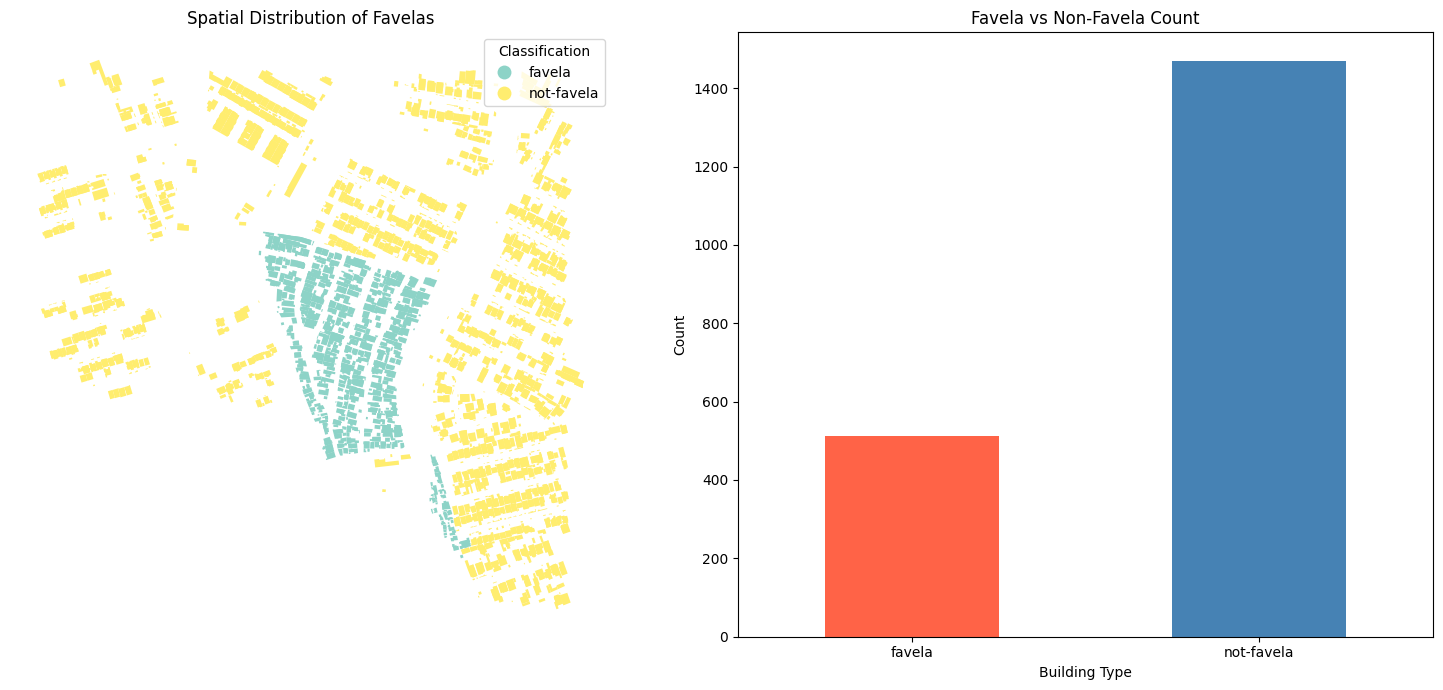

In [6]:
# from ground_truth import classify_and_analyze_favelas

try:
    classified_buildings, analysis = classify_and_analyze_favelas(
        clean_buildings,
        type_column='nome_count'
    )

    ground_truth_gdf = classified_buildings

    # merge buildings
    clean_buildings['label'] = classified_buildings['label']

    plt.show()

except Exception as e:
    print(f"Error during classification analysis: {str(e)}")


# XG Boost Classification

In [7]:
results = run_xgboost(ground_truth_gdf)

# save results
save_xgboost_results(results, save_outputs_to, site_name)

ground_truth_gdf = results['updated_gdf']
metrics = results['metrics']
xgb_model = results['model']
X_imputed = results['X_imputed']
X = results['X']
X_train = results['X_train']

print(results['classification_report'])


Target value counts:
0    1469
1     511
Name: count, dtype: int64
Accuracy: 88.63636363636364
Classification Report:
{'favela': {'precision': 0.9052287581699346, 'recall': 0.9453924914675768, 'f1-score': 0.9248747913188647, 'support': 293.0}, 'not-favela': {'precision': 0.8222222222222222, 'recall': 0.7184466019417476, 'f1-score': 0.7668393782383419, 'support': 103.0}, 'accuracy': 0.8863636363636364, 'macro avg': {'precision': 0.8637254901960785, 'recall': 0.8319195467046622, 'f1-score': 0.8458570847786033, 'support': 396.0}, 'weighted avg': {'precision': 0.8836386743249488, 'recall': 0.8863636363636364, 'f1-score': 0.8837696207448905, 'support': 396.0}}
Feature Importances:
                        Feature  Importance
4   mean_interbuilding_distance    0.141394
8                  facade_ratio    0.111951
2                           lal    0.085522
14               perimeter_wall    0.079695
0                          area    0.059036
6                       corners    0.046728
20     

## Save SHAP Results

In [ ]:
shap_results = calculate_shap_results(xgb_model, X_imputed, metrics, ground_truth_gdf)

save_shap_results(shap_results, output_dir, site_name)


c:\Users\miles\favela_analysis\src\shap_calculator.py:82: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  updated_gdf.to_file(shapefile_path)


SHAP results successfully saved to: C:\Users\miles\favela_analysis\output\palmeras\palmeras
